### Hybrid Base Model: MNIST Data

Added Quantum layer based on custom defined quantum circuit in the classical base model cnn architecture

In [1]:
# Required imports
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers

import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix as cmatrix

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Loading the data which was processed and saved while executing nb 2
data = np.load('../data/mnist01.npz', allow_pickle=True)

x_train = data["x_train"]
y_train = data["y_train"]
x_test = data["x_test"]
y_test = data["y_test"]

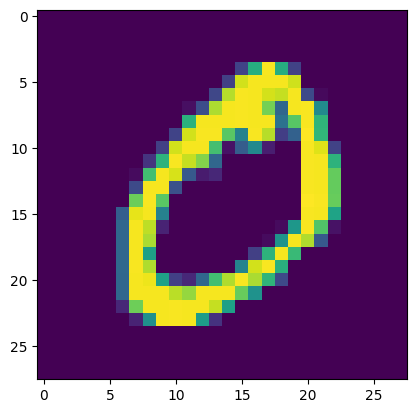

In [3]:
# sample data plot
plt.imshow(x_train[0])

In [4]:
# Create pairs of images and labels
def create_pairs(images, labels):
    pairs = []
    pair_labels = []

    num_classes = len(np.unique(labels)) # 2
    digit_indices = [np.where(labels == i)[0] for i in range(num_classes)]

    for idx1 in range(len(images)):
        x1, label1 = images[idx1], labels[idx1]
        idx2 = np.random.choice(digit_indices[label1])
        x2 = images[idx2]

        # if x1==x2, label set to 1
        pairs.append([x1, x2])
        pair_labels.append(1)

        # if x1!=x2, label set to 0
        label2 = (label1 + np.random.randint(1, num_classes)) % num_classes
        idx2 = np.random.choice(digit_indices[label2])
        x2 = images[idx2]
        pairs.append([x1, x2])
        pair_labels.append(0)

    return np.array(pairs), np.array(pair_labels)

In [5]:
pairs_train, labels_train = create_pairs(x_train, y_train)
pairs_test, labels_test = create_pairs(x_test, y_test)

In [6]:
# Defining quantum circuit for quantum layer
n_qubits = 4
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

(<Figure size 500x500 with 1 Axes>, <Axes: >)

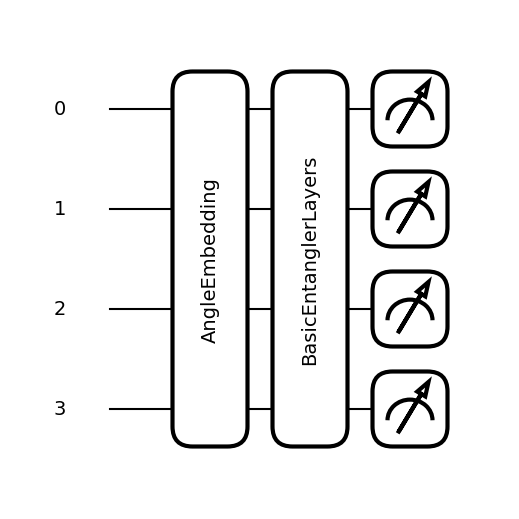

In [7]:
# Plotting a sample circuit with random weights for visualization
weights = np.random.random((n_layers, n_qubits))
X=[1,2,3,4]
qml.draw_mpl(quantum_circuit)(X,weights)

In [8]:
# Define trainable weights for the quantum circuit (will be used in training)
weight_shapes = {"weights": (n_layers, n_qubits)}
quantum_layer = qml.qnn.KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits)

In [9]:
# Base model from classical nb, adding qlayer in between
def create_quantum_cnn(input_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu')) # Conv layer 1
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu')) # Conv layer 2
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))

    # ------ Quantum layer added in nb 2 classical base architecture
    # Reducing dimensions to match n_qubits
    model.add(layers.Dense(n_qubits)) 
    # Quantum layer
    model.add(quantum_layer)
    # Dense layer after quantum layer
    model.add(layers.Dense(n_qubits, activation='relu'))
    # --------------------------------------------------------------
    
    model.add(layers.Dense(1, activation='sigmoid'))  
    return model

In [10]:
# Contrastive Pair loss
def contrastive_loss(margin=1.0):
    def loss(y_true, dist):
        y_true = tf.cast(y_true, tf.float32)
        square_dist = tf.square(dist)
        margin_square = tf.square(tf.maximum(margin - dist, 0))
        return tf.reduce_mean(y_true * square_dist + (1 - y_true) * margin_square)
    return loss

# Siamese Network model
def create_siamese_network(input_shape):
    base_model = create_quantum_cnn(input_shape)

    input_0 = layers.Input(shape=input_shape)
    input_1 = layers.Input(shape=input_shape)

    processed_0 = base_model(input_0)
    processed_1 = base_model(input_1)

    distance = layers.Lambda(lambda embeddings: tf.sqrt(tf.reduce_sum(tf.square(embeddings[0] - embeddings[1]), axis=-1)), output_shape=(1,)
                            )([processed_0, processed_1])

    
    model = models.Model([input_0, input_1], distance)
    
    return model

In [11]:
# Training
tf.get_logger().setLevel('ERROR')

checkpoint_path = "hybrid_cnn_base_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

input_shape = pairs_train.shape[2:]
siamese_network = create_siamese_network(input_shape)

siamese_network.compile(loss=contrastive_loss(), optimizer=optimizers.Adam())

history = siamese_network.fit([pairs_train[:, 0], pairs_train[:, 1]], labels_train,
    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
    epochs=10,
    batch_size=32,
    callbacks=[cp_callback]
)

Epoch 1/10
792/792 [==============================] - ETA: 0s - loss: 0.1089
Epoch 1: saving model to hybrid_cnn_base_1\cp.ckpt
792/792 [==============================] - 737s 930ms/step - loss: 0.1089 - val_loss: 0.0039
Epoch 2/10
792/792 [==============================] - ETA: 0s - loss: 0.0012
Epoch 2: saving model to hybrid_cnn_base_1\cp.ckpt
792/792 [==============================] - 707s 893ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 3/10
792/792 [==============================] - ETA: 0s - loss: 3.4113e-04
Epoch 3: saving model to hybrid_cnn_base_1\cp.ckpt
792/792 [==============================] - 582s 735ms/step - loss: 3.4113e-04 - val_loss: 7.1361e-04
Epoch 4/10
792/792 [==============================] - ETA: 0s - loss: 1.5130e-04
Epoch 4: saving model to hybrid_cnn_base_1\cp.ckpt
792/792 [==============================] - 579s 731ms/step - loss: 1.5130e-04 - val_loss: 5.8459e-04
Epoch 5/10
792/792 [==============================] - ETA: 0s - loss: 7.8923e-05
Epoch 5: sa

In [12]:
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 1)                    514793    ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 lambda (Lambda)             (None,)                      0         ['sequential[0][0]',      

### Model Evaluation

<Axes: title={'center': 'Learning History'}>

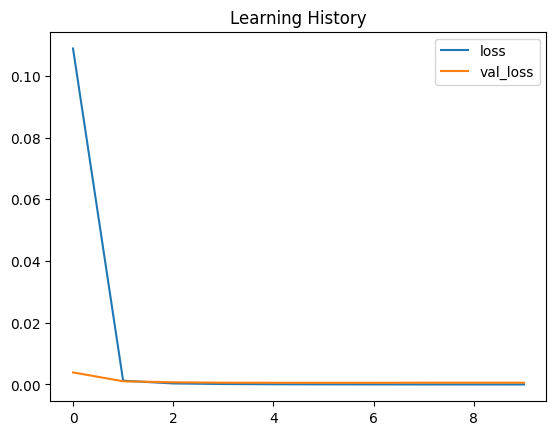

In [13]:
pd.DataFrame(history.history).plot(title="Learning History")

In [15]:
distance = siamese_network.predict([pairs_test[:, 0], pairs_test[:, 1]])

133/133 [==============================] - 38s 288ms/step


In [16]:
def distances_to_labels(distances, threshold=0.5):
    return (distances <= threshold).astype(int)

In [18]:
y_pred = distances_to_labels(distance)

In [19]:
def evaluate_precision_recall_accuracy(y_true, y_pred, threshold=0.5):
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    true_positives = np.sum((y_true == 1) & (y_pred_binary == 1))
    false_positives = np.sum((y_true == 0) & (y_pred_binary == 1))
    false_negatives = np.sum((y_true == 1) & (y_pred_binary == 0))
    true_negatives = np.sum((y_true == 0) & (y_pred_binary == 0))
    
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    accuracy = (true_positives + true_negatives) / len(y_true)
    
    return precision, recall, accuracy

evaluate_precision_recall_accuracy(labels_test,y_pred)

(tensor(0.99905437, requires_grad=True),
 tensor(0.99905437, requires_grad=True),
 tensor(0.99905437, requires_grad=True))

In [20]:
def make_cm(y_true,y_pred,classes=None,figsize=(10,10),text_size=15):
  cm = cmatrix(y_true,tf.round(y_pred))
  cm_norm = cm.astype("float")/cm.sum(axis=1)[:,np.newaxis] # normalise confusion matrix
  n_class = cm.shape[0]

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm,cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels=classes
  else:
    labels=np.arange(cm.shape[0])

  ax.set(title="Confusion Matrix", 
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_class),
        yticks=np.arange(n_class),
        xticklabels=labels,
        yticklabels=labels)

  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ax.yaxis.label.set_size(text_size)
  ax.xaxis.label.set_size(text_size)
  ax.title.set_size(text_size)


  threshold = (cm.max()+cm.min())/2

  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,f"{cm[i,j]} ({cm_norm[i,j]*100:.1f})%",
            horizontalalignment="center",
            color="white" if cm[i,j]>threshold else "black",
            size=text_size)

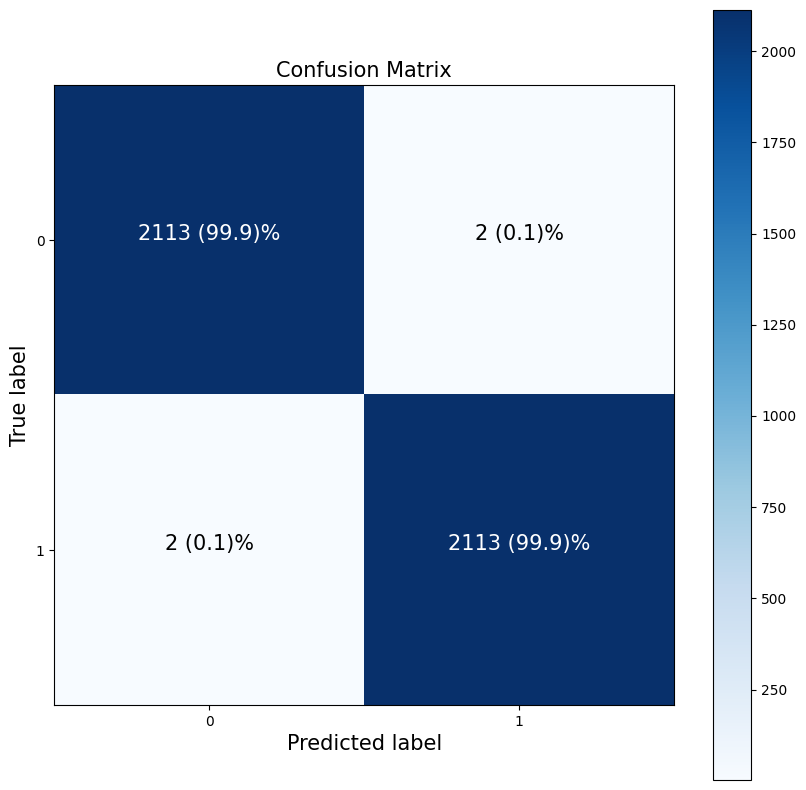

In [22]:
import itertools
make_cm(labels_test,y_pred,["0","1"])

In [23]:
def plot_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()


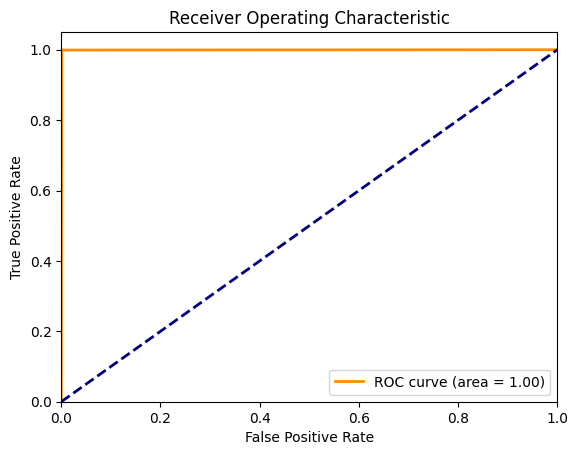

In [24]:
plot_auc(labels_test,y_pred)

### Saving and Loading the model

In [28]:
model = create_siamese_network(input_shape)
model.compile(loss=contrastive_loss(), optimizer=optimizers.Adam())
# Evaluate the model
loss = model.evaluate([pairs_test[:, 0], pairs_test[:, 1]], labels_test, verbose=2)
print("Untrained model, loss: {:5.2f}%".format(100 * loss))

133/133 - 42s - loss: 0.4985 - 42s/epoch - 319ms/step
Untrained model, loss: 49.85%


In [30]:
# Loads the weights
model.load_weights(checkpoint_path)
# Re-evaluate the model
loss = model.evaluate([pairs_test[:, 0], pairs_test[:, 1]], labels_test, verbose=2)
print("Restored model, loss: {:5.2f}%".format(100 * loss))

133/133 - 42s - loss: 5.7383e-04 - 42s/epoch - 318ms/step
Restored model, loss:  0.06%
